# CLASSIFICATION TEXT for UNBALANCED dataset

In this notebook we are going to explore different ways to address the problem of *classifictation of text messages*. 

In particular, the messages which we are provided turn out to be written in a uncomprehensible language. This might be  the case of messages encrypted for secrecy reasons (military, privacy, ...) or just a collection of sentences written in an unkown language that we wish to classify. For example messages written in two different historical periods in a language for which no translating schemes are available nowdays. In this case, for example, the problem might be to classify sentences for which we ignore the period to which they belong to, having at our disposal only a limited set of messages (train set) for which the historical classification is available.

The following are the steps that we will take:
1. Pre-processing:
    1. Import the dataset and perform some preliminary analysis:
         - **Note**: since the language has not a known structure nor a known semantic, we will not be able to perform any analysis of the type of lemmatization or stemming or remove special characters, which is the usual way to proceed when dealing with text classification.<br>
         - The dataset will appear to be **unbalanced**, in the sense that the number of messages for the two classes in not the same.<br>
         - The labels used here are the usal '0' and '1', where the latter indicates the smaller class.
    2. We will observe that an important feature which distinguish the messages is the distribution of their **lengths**, which provides an additional feature which might help in the classification problem.
    3. It follows the step of *Vectorization*, namely the step where raw text is converted into arrays of numbers. As previously said, we don't know the specifics of the language used to write this messages, and it might be the case that even a **word made of a single character** might carry **essential information**. In this respect we have to tweak a little the vectorisation procedure (which will be carried out using the sklearn vecotirser) and force the program to include the single-character meaningful words. We will store the words (features) then in a vector called 'vocabulary'.<br>
2. Classification using **Logistic regression**:
    1. The first approach we will try is to use a simple logistic regression algorithm. The advantage of this approach is the relatively cheap computational cost required and the adaptability of such algorithm to problems with big number of features. 
        - We will implement a *Pipeline* and use *GridSearchCV* in order to fit the model with different parameters.<br>
        - As the dataset we noticed being unbalanced, in ored to measure the effectivness of these models and choose the best one, we will guide our analysis using the **f1 score**. (A much similar index to the f1 score is the Matthews score. We will show how these two metrics are in fact linked and therefore we will restrict our anaylsis to the f1 score.)<br>
        - In this section we will also consider the possibility of improving our model by adding the length of the messages as an extra frature.
3. Classification using **Neural Networks**:
    1. The second approach that we will try makes use of sequential Neural Network models built with Keras. The advantage of this second approach is that this model is able to 'learn' the underlying semantic embedded in the language on its own. The downside of this approach is the computational cost which is rather consistent. The key-parameters in this section are:
        - *Regularization* and *dropout*: while the former enters directly in the form of the cost function as the usual regularization term (we choose a l2 regularizer) the latter determines the percentage of the nodes that are randomly excluded during the fitting period. <br>
        - *Number of hidden layers*: the higher the number, the more favourable is for the system to learn structures as it allows structured interplay between groups of words. Of course higher the number, higher is the risk to incur in overfitting.<br>
        - *Number of neurons* per layer: same logic used for the number of layer applies here. Also at risk of overfitting.<br>
        - *Threshold* values: is the set of different threshold that will be used for the classification of each sample into class 0 or 1. By default, for a predicted probability $p$ of a single sample $x$,the thumb-rule used to determine to which class the sample belongs to is: if $p<0.5 $, then $x \in$ class $0$, $x \in$ class $1$ otherwise. The idea is that setting different threshold values (smaller than 0.5) helps the model in classifying more samples in the weak class 1, improving in fact the recall score.<br>
    2. How the algorithm is structured? In order to avoid heavy and too long computations, we minimised the number of 'for loops' to only three:
        - The most external one loops over different values of number of neurons per layer. <br>
        - The middle loop works out the different thresholds for the fixed size of the leayer. In this loop the model is created. Note, at first it might seems more natural to create the model in the upper loop, namely the one over the number of neurons, since the model itself would not depend on the threshold which interveines only in the classification step. This, though, is not correct as in order to evaluate the performance of the algorithm we created some callback which operates at the end of each epoch run and depend on the threshold value.<br>
        - The most insternal loop works out a cross validation procedure, looping over the cv value. In this loop the model is fitted.<br>
    3. What is left from the for loops? The parameters that have to be set manually are the number of layers, the dropout and regularization values.
        - The first step is to have a some idea of what the model does when no regularization nor dropout is set. The overfitting is a natural consequence.<br>
        - Setting the values to regularization = 0.001 and dropout = 0.3, we are now ready to explore what the results are.

**Note**: some boxes show errors. This is becuase during the execution of them the parameter verbose was set on 1. In order to guarantee a certain level of readability in GitHub, I re run the code forcing it to produce this error so to keep the cell dimension small. Running again the code from the beginning with the parameter verbose set oto 0 will produce the optimal result.

# 0. Import libraries and packages needed: 


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import warnings
warnings.filterwarnings('ignore')
import nltk
from collections import defaultdict
from pprint import pprint              ## taylored configuration for print()
from time import time
#np.random.seed(26)
from keras import __version__ as used_keras_version

import scikitplot as skplt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, svm, model_selection, metrics, preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, NearMiss, InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,RepeatedEditedNearestNeighbours,AllKNN,
                                    NeighbourhoodCleaningRule,OneSidedSelection,TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# 1. Import dataset & data-mining:

In [2]:
words_df = pd.read_table('OK_words.csv',encoding="ISO-8859-1",header = None, sep = ',',
                      names =['message_count','word_in_mess_count','word'])

#words = pd.read_table('words.txt',encoding="ISO-8859-1",header = None, sep = ',', 
                                        #names =['message_count','word_in_mess_count','word'])
labels = pd.read_csv('labels.csv', header= None, names = ['message_count','label'])

In [3]:
print(words_df.head())

   message_count  word_in_mess_count    word
0              0                   1      l7
1              0                   2   3rej8
2              0                   3  p3û7rl
3              0                   4   y7jre
4              0                   5   uûöbá


In [4]:
print(labels.head())

   message_count  label
0              0    0.0
1              1    0.0
2              2    1.0
3              3    0.0
4              4    0.0


In [5]:
if words_df['message_count'].max() +1 == labels['message_count'].count():
    print('The number of sentences collected is {}'.format(labels['message_count'].count()))

The number of sentences collected is 5572


### Unbalanced dataset

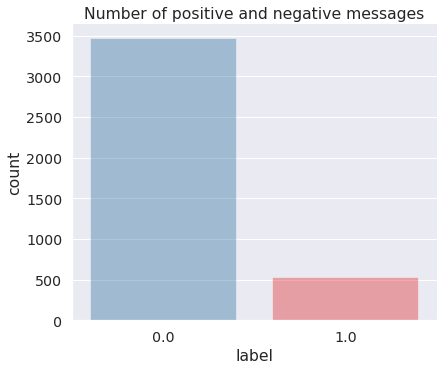

The ratio of negative/positive messages is: 6.4766355140186915


In [6]:
sns.factorplot(x="label", data=labels, kind="count", aspect=1.2 , palette=['#1F77B4', '#FF0E16'] ,alpha=0.4 )
plt.title('Number of positive and negative messages')
plt.show();

print('The ratio of negative/positive messages is: {}'.
      format(len(labels[labels.label==0])/len(labels[labels.label==1])))

### Quality check and search of empty cells

In [7]:
print('Number of empty cells in the words dataframe is:')
print(words_df.isnull().sum())
# words.dropna()   is not required
print()
print('Number of empty cells in the labels dataframe is:') 
print(labels.isnull().sum())

Number of empty cells in the words dataframe is:
message_count         0
word_in_mess_count    0
word                  0
dtype: int64

Number of empty cells in the labels dataframe is:
message_count       0
label            1572
dtype: int64


Note: out of 5572 sentensces, the number 1572 refers then to the sentences that have no labels and that we wish to classify.

### Create a new dataset containing the sentences

In [8]:
messages_list = []
length_list = []

for i in range(words_df['message_count'].max()+1):
    temp = str()
    length_list.append(len(words_df[words_df.message_count == i].word))
    for word in words_df[words_df.message_count == i].word:
        temp +=  word + ' '
    if len(words_df[words_df.message_count == i].word)>1:
        temp = temp[:-1]         ## Remove the last empty space at the end of each message.
    messages_list.append(temp)   

messages = pd.DataFrame({'message': messages_list,'length':length_list,'label':labels.label}
                        , index = list(np.arange(0,words_df['message_count'].max()+1,1)))

In [9]:
print('Here is the first reconstructed message:')
print(messages_list[0])

Here is the first reconstructed message:
l7 3rej8 p3û7rl y7jre uûöbá öxöj8öð8â 7r8á jr ð3ljs r lûâöe a7û8z 8ö â ð311âe ujrâ emâûâ l7e ön7ûâ aöe


#### Statistics and quality check

In [10]:
print(messages.count())

message    5572
length     5572
label      4000
dtype: int64


In [11]:
print(messages[messages.label.isin([0,1])].groupby('label').describe())

       length                                                    
        count       mean        std  min   25%   50%   75%    max
label                                                            
0.0    3465.0  14.684560  12.031716  0.0   7.0  11.0  19.0  190.0
1.0     535.0  25.850467   6.163204  2.0  24.0  27.0  30.0   40.0


In [12]:
print(messages[messages.length ==0].head())

     message  length  label
3374               0    0.0
4822               0    NaN


#### Remove empty messages

In [13]:
messages = messages[messages.length >0]
print(messages.count())

message    5570
length     5570
label      3999
dtype: int64


As notices before, there were two empty messages in the data set. We see that the label counter dropped to 3999. That means that out of the two, one was already labelled while the other was in the list of sentences that we wanted to classify.

### A possibly interesting feature: length of sentences.

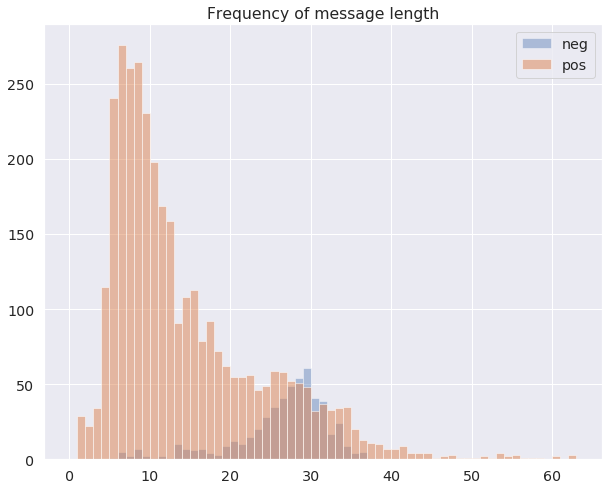

In [14]:
bins = np.arange(0,64,1 )
plt.subplots(figsize=(10, 8))
plt.hist(messages[messages.label.isin([1])].length, bins, alpha=0.4, label='neg')
plt.hist(np.array(messages[messages.label.isin([0])].length), bins, alpha=0.5, label='pos')
plt.legend(loc='upper right')
plt.title('Frequency of message length')
plt.show();

In [15]:
print(messages.head())

                                             message  length  label
0  l7 3rej8 p3û7rl y7jre uûöbá öxöj8öð8â 7r8á jr ...      20    0.0
1                            7ï 8öû p7ïjrl aj1 3 7rj       6    0.0
2  1ûââ âreûá jr g ö aï8á u7ny e7 ajr 1ö u3y 1jrö...      33    1.0
3        3 z3r söá s7 âöû8á m7û 3 u ö8ûâözá emâr söá      11    0.0
4  röm j z7r e emjrï mâ l7âs e7 3s1 mâ 8jxâs öû73...      14    0.0


#### Split among labelled and not-labelled 

In [16]:
labelled_messages = messages[messages.label.isin([0,1])]
not_labelled_messages = messages[pd.isna(messages.label)]

In [17]:
print(labelled_messages.head())
print(labelled_messages.count())

                                             message  length  label
0  l7 3rej8 p3û7rl y7jre uûöbá öxöj8öð8â 7r8á jr ...      20    0.0
1                            7ï 8öû p7ïjrl aj1 3 7rj       6    0.0
2  1ûââ âreûá jr g ö aï8á u7ny e7 ajr 1ö u3y 1jrö...      33    1.0
3        3 z3r söá s7 âöû8á m7û 3 u ö8ûâözá emâr söá      11    0.0
4  röm j z7r e emjrï mâ l7âs e7 3s1 mâ 8jxâs öû73...      14    0.0
message    3999
length     3999
label      3999
dtype: int64


In [18]:
print(not_labelled_messages.tail())
print(not_labelled_messages.count())

                                                message  length  label
5567  emjs js emâ grz ejnâ aâ möxâ eûjâz g u7reöue 3...      33    NaN
5568               aj88 qc ð l7jrl e7 âsy8örözâ 1û m7nâ       8    NaN
5569  yjeá aös jr n77z 17û emöe s7 örá 7emâû s3llâse...      10    NaN
5570  emâ l3á zjz s7nâ ðjeumjrl ð3e j öueâz 8jïâ j z...      27    NaN
5571                          û718 jes eû3â e7 jes rönâ       6    NaN
message    1571
length     1571
label         0
dtype: int64


#### Words made of a single character

Usually when dealing with text pre-processing and text analysis it is a good practice to avoid using words made of a single alphanumeric character. In this case though, being our data set encrypted in a fashion which is not known, we must be sure we don't lose much information in not using such words. In particular, in the following script, we will vectorise the raw text-data into numeric vectors, by using the *TfIdf Vectorizer*. This tool, by default, will not consider tokens (words) made of a single character. So before applying a vectorisation to our dataset, let's explore a bit what are the information that such words are carrying.

# 2. Split data into train and test sets

In [19]:
words = list(set(words_df.word))  # A list of all the words contained in our dataset

w1 = [] # list which will contain the words made of 1 single character
for word in words:
    if len(word)==1:
        w1.append(word)
print('Number of words made of one single character is: {}'.format(len(w1)))

Number of words made of one single character is: 41


In [20]:
print(w1)

['q', 'e', 'û', 'm', 'g', 'ì', 's', 'r', 'o', 'ó', 'ö', '5', 'p', 'ª', '7', 'l', '8', 'u', 'j', 'ð', 'ï', 'b', 'z', 'n', 'd', '0', '4', '3', '1', 'â', 'õ', 'ò', 'y', 'a', '2', 'k', 'c', 'è', 'á', 'h', 'x']


The idea is that whereas most of them will be equally contained in both classes, a little part might contain meaningful words, which for example appear predominently in one class.

In [21]:
pos_messages = messages[messages.label.isin([1])]
neg_messages = messages[messages.label.isin([0])]

di_w1_pos_freq = dict() #dictionary of words in w1 and their frequencies across positive messages
di_w1_neg_freq = dict() #dictionary of words in w1 and their frequencies across negative messages
di_w1_charact_freq = dict() #dictionary of words in w1 and the ration of thei frequencies across positive/negative messages

In [22]:
for x in w1:
    di_w1_pos_freq[x]= sum(x in message for message in pos_messages.message)
    di_w1_neg_freq[x]= sum(x in message for message in neg_messages.message)
    di_w1_charact_freq[x] = sum(x in message for message in pos_messages.message)/(sum(x in message for message in neg_messages.message)+1)
# Note the +1 in order to divide by zero.

In [23]:
print('Words made of one single character and their characterising frequency are:\n')
for x in di_w1_charact_freq.items():
    print(x[0],np.round(x[1],6))

Words made of one single character and their characterising frequency are:

q 0.010101
e 0.164537
û 0.180007
m 0.170548
g 1.7
ì 4.31
s 0.181943
r 0.169492
o 0.0
ó 0.988439
ö 0.162523
5 9.6875
p 0.254697
ª 3.552941
7 0.161965
l 0.177874
8 0.190353
u 0.236648
j 0.165245
ð 0.225902
ï 0.17851
b 0.672316
z 0.194467
n 0.200161
d 7.558824
0 7.05
4 6.02
3 0.191639
1 0.252496
â 0.162855
õ 5.342857
ò 0.090909
y 0.284659
a 0.215525
2 0.568807
k 6.619048
c 0.034091
è 6.714286
á 0.186467
h 1.849398
x 0.293452


In [24]:
print('Words with class-characterising frequency are:')
for x in di_w1_charact_freq.items():
    if (x[1]> 4 or x[1]< 1/28):
        print(x[0],np.round(x[1],6))

Words with class-characterising frequency are:
q 0.010101
ì 4.31
o 0.0
5 9.6875
d 7.558824
0 7.05
4 6.02
õ 5.342857
k 6.619048
c 0.034091
è 6.714286


In the above list, greater frequency depict a strong link between the word and the postive class 1. On the other hand, 
little frequency implies a link with the positive class 0.

### Vocabulary
Let's create then our vocabulary:

In [25]:
def vocabulary_maker(all_words_list,remove_words_dict,a,b):
    '''
    This function takes as input:
        - all_words_list: the list of all the words in the data set.
        - emove_words_dict: the dictionary containing the words in w1 (one character word).
        - a,b: the two extrema which determine class 0 and class 1 in terms of frequency.
    Returns:
        - vocabulary:  a list of all the words except those in w1 with meaningless frequencies.
        
    '''
    remove_words = []
    for x in remove_words_dict:
        if (a <= x[1] <= b ):
            remove_words.append(x[0])
    vocabulary = list()
    vocabulary = all_words_list.copy()
    for word in remove_words:
        vocabulary.remove(str(word))
    return vocabulary

vocabulary = vocabulary_maker(words,di_w1_charact_freq.items(),1/28,4)

#### Shuffle the dataset so to minimise risk of correlation between sentences

In [26]:
labelled_messages = labelled_messages.reindex(np.random.permutation(labelled_messages.index ))

Note: in fact this is is over-precautios, as in the following we will split the dataset into train and test set and apply also in there a preventive random shuffling.

#### Transform raw data into numerical fomrat: Tf-Idf (no normalisation)

In [27]:
vectorizer = TfidfVectorizer(norm=None, decode_error = 'ignore',lowercase= False, encoding="ISO-8859-1", 
                    token_pattern = '(?u)\\b\\w+\\b',vocabulary = vocabulary)
# Note:   token_pattern = '(?u)\\b\\w+\\b' 
        # as mentiond earlier, by default Tfidf Vectorizer does not consider words of a single 
        # character. So this expression allows to take into account for them as well.
        # The vocabulary instance eliminates the meaning less words. Probably overshooting as the TfIdf would take care of them anyway.
        

In [28]:
X_labelled  = vectorizer.fit_transform(labelled_messages.message)
X_lab = X_labelled.toarray()

In [29]:
print('X_lab shape is {}.\nThe first coordinate indicates the number of labelled messages while the second is the number of features extracted. \nIn X_lab, the maximum value is {}, the minimum value is {}'.format(X_lab.shape,X_lab.max(),X_lab.min()))


X_lab shape is (3999, 8683).
The first coordinate indicates the number of labelled messages while the second is the number of features extracted. 
In X_lab, the maximum value is 76.56592347113404, the minimum value is 0.0


#### New dataset where length information is included

In [30]:
lengths =  np.array(labelled_messages[labelled_messages.length > 0].length).reshape(-1,1)
X_len_lab = np.hstack((X_lab,lengths))

#### FInally split into training and test set for both cases where lengths were included or not 

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_lab,labelled_messages.label,test_size = 0.2)
X_len_train, X_len_test, y_len_train, y_len_test = model_selection.train_test_split(X_len_lab,labelled_messages.label,test_size = 0.2)

# 3. Classification using Logistic Regression

## 3.1 No length in features

We first start without using the additional information provided by the length of the messages.

In order to find the best model, we are going to use GridSearchCV. This tools will scan through all the possible combination of parameters and return the best one.

In [32]:
pipeline_LR = Pipeline([
    ('clf', LogisticRegression(random_state=0, solver='saga')),      
])

In [33]:
parameters_LR = {
    'clf__C': (0.1,0.25,0.5,0.75,0.9,1),   
    'clf__penalty': ('none','l1', 'l2',),
    'clf__max_iter': (10, 20, 50),
    'clf__multi_class': ('ovr','multinomial')
}
#scoring = {'f1': 'f1'}
#scoring = {'f1': 'f1', 'MCC': make_scorer(matthews_corrcoef)}

#### Matthews - metric

In [34]:
grid_search_LR = GridSearchCV(pipeline_LR, parameters_LR, scoring=make_scorer(matthews_corrcoef), cv=5,n_jobs=-1, verbose=1)                                                          
print("Performing grid search...")
print()
print("pipeline:", [name for name, _ in pipeline_LR.steps])
print("parameters:")
pprint(parameters_LR)
t0 = time()

grid_search_LR.fit(X_train, y_train)
print("done in {} s".format(time() - t0))
print()

Performing grid search...

pipeline: ['clf']
parameters:
{'clf__C': (0.1, 0.25, 0.5, 0.75, 0.9, 1),
 'clf__max_iter': (10, 20, 50),
 'clf__multi_class': ('ovr', 'multinomial'),
 'clf__penalty': ('none', 'l1', 'l2')}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 53.5min finished


done in 3265.3564767837524 s



In [35]:
print('Best Matthews score: {}'.format(grid_search_LR.best_score_))
print("Best parameters set:")
best_parameters_LR = grid_search_LR.best_estimator_.get_params()
for param_name in sorted(parameters_LR.keys()):
    print("\t%s: %r" % (param_name, best_parameters_LR[param_name]))
print()
print("Best estimator is: {}".format(grid_search_LR.best_estimator_))

Best Matthews score: 0.9302094173651915
Best parameters set:
	clf__C: 0.9
	clf__max_iter: 50
	clf__multi_class: 'multinomial'
	clf__penalty: 'l1'

Best estimator is: Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=0.9, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=0, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)


In [36]:
best_LR = LogisticRegression(C=0.9, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=0, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False)

In [37]:
best_LR.fit(X_train,y_train)
y_test_best_pred = best_LR.predict(X_test)
MCC_score_best_LR = matthews_corrcoef(y_test,y_test_best_pred)

print('MCC on test set: {}'.format(MCC_score_best_LR))

MCC on test set: 0.9216967226108809


#### f1 - metric

In [39]:
grid_search_LR = GridSearchCV(pipeline_LR, parameters_LR, scoring='f1', cv=5,n_jobs=-1, verbose=1)                                                          
print("Performing grid search...")
print()
print("pipeline:", [name for name, _ in pipeline_LR.steps])
print("parameters:")
pprint(parameters_LR)
t0 = time()

grid_search_LR.fit(X_train, y_train)
print("done in {} s".format(time() - t0))
print()




Performing grid search...

pipeline: ['clf']
parameters:
{'clf__C': (0.1, 0.25, 0.5, 0.75, 0.9, 1),
 'clf__max_iter': (10, 20, 50),
 'clf__multi_class': ('ovr', 'multinomial'),
 'clf__penalty': ('none', 'l1', 'l2')}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 56.7min finished


done in 3456.343016386032 s



In [40]:
print('Best score: {}'.format(grid_search_LR.best_score_))
print("Best parameters set:")
best_parameters_LR = grid_search_LR.best_estimator_.get_params()
for param_name in sorted(parameters_LR.keys()):
    print("\t%s: %r" % (param_name, best_parameters_LR[param_name]))
print()
print("Best estimator is: {}".format(grid_search_LR.best_estimator_))

Best score: 0.9371276135959417
Best parameters set:
	clf__C: 0.9
	clf__max_iter: 50
	clf__multi_class: 'multinomial'
	clf__penalty: 'l1'

Best estimator is: Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=0.9, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=0, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)


From the Cross-Validation process above we determine that the best model is:

In [41]:
best_LR = LogisticRegression(C=0.75, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l1', random_state=0, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False)

**Note**: for both Matthews and f1, we get the same best model. This is because the two metrics are intimately related to eachother. From now one we will chose the f1 as reference score.

In [42]:
best_LR.fit(X_train,y_train)
y_test_best_pred = best_LR.predict(X_test)
f1_score_best_LR = f1_score(y_test,y_test_best_pred)

print(f1_score_best_LR)

0.9150943396226416


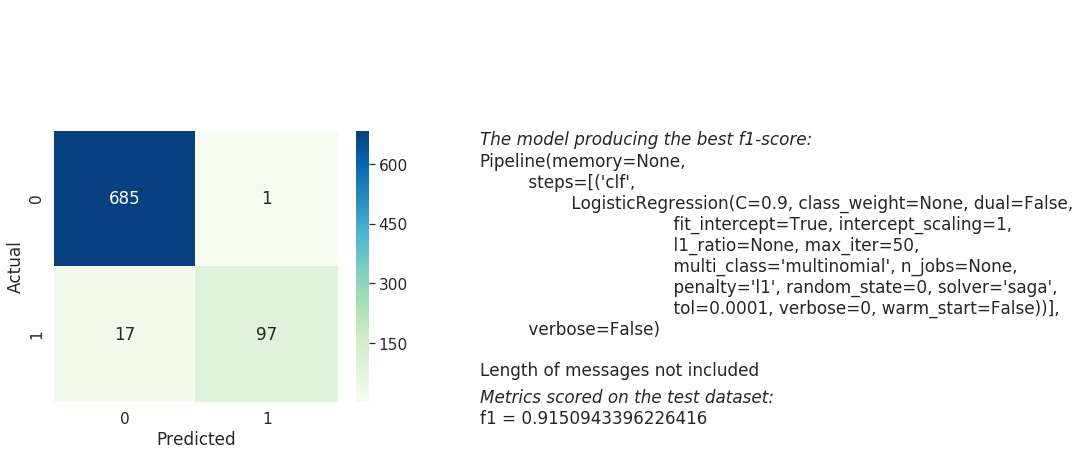

In [59]:
#y_true_label = ["0", "1"]
#y_pred_labe = ["0", "1"]
data = confusion_matrix(y_true=y_test, y_pred=y_test_best_pred)
df_cm = pd.DataFrame(data, columns=np.unique(["0", "1"]), index = np.unique(["0", "1"]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.set(font_scale=1.4)#for label size
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size annot=True, fmt="d"
sns.heatmap(df_cm, cmap="GnBu",annot=True,fmt="d")
plt.subplot(1,2,2)
plt.text(0,0.95,'The model producing the best f1-score:', fontstyle = 'italic')
plt.text(0,0.25,'\n\n\n\n\n\n\n{}'
      .format(grid_search_LR.best_estimator_))
plt.text(0,0.1,'Length of messages not included')
plt.text(0,0,'Metrics scored on the test dataset:', fontstyle = 'italic')
plt.text(0,-0.08,'f1 = {}'.format(f1_score_best_LR))
plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
plt.savefig('Confusion_matrix_best_LR_no_length.png')

## 3.2 Length included

In [60]:
grid_search_LR_len = GridSearchCV(pipeline_LR, parameters_LR, scoring='f1', cv=5,n_jobs=-1, verbose=1)
print("Performing grid search...")
print()
print("pipeline:", [name for name, _ in pipeline_LR.steps])
print("parameters:")
pprint(parameters_LR)
t0 = time()
grid_search_LR_len.fit(X_len_train, y_len_train)
print("done in {} s".format(time() - t0))
print()

Performing grid search...

pipeline: ['clf']
parameters:
{'clf__C': (0.1, 0.25, 0.5, 0.75, 0.9, 1),
 'clf__max_iter': (10, 20, 50),
 'clf__multi_class': ('ovr', 'multinomial'),
 'clf__penalty': ('none', 'l1', 'l2')}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 55.6min finished


done in 3390.3454706668854 s



In [61]:
print("Best score: %0.3f" % grid_search_LR_len.best_score_)
print("Best parameters set:")
best_parameters_LR_len = grid_search_LR_len.best_estimator_.get_params()
for param_name in sorted(parameters_LR.keys()):
    print("\t%s: %r" % (param_name, best_parameters_LR_len[param_name]))
print()
print("Best estimator is: {}".format(grid_search_LR_len.best_estimator_))

Best score: 0.910
Best parameters set:
	clf__C: 0.75
	clf__max_iter: 50
	clf__multi_class: 'multinomial'
	clf__penalty: 'l1'

Best estimator is: Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=0.75, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=0, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)


In [62]:
best_LR_len = LogisticRegression(C=0.75, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=0, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False)

In [63]:
best_LR_len.fit(X_len_train,y_len_train)
y_test_best_pred_len = best_LR_len.predict(X_len_test)
f1_score_best_LR_len = f1_score(y_len_test,y_test_best_pred_len)
print('f1 score on the test set: {}'.format(f1_score_best_LR_len))

f1 score on the test set: 0.9707602339181286


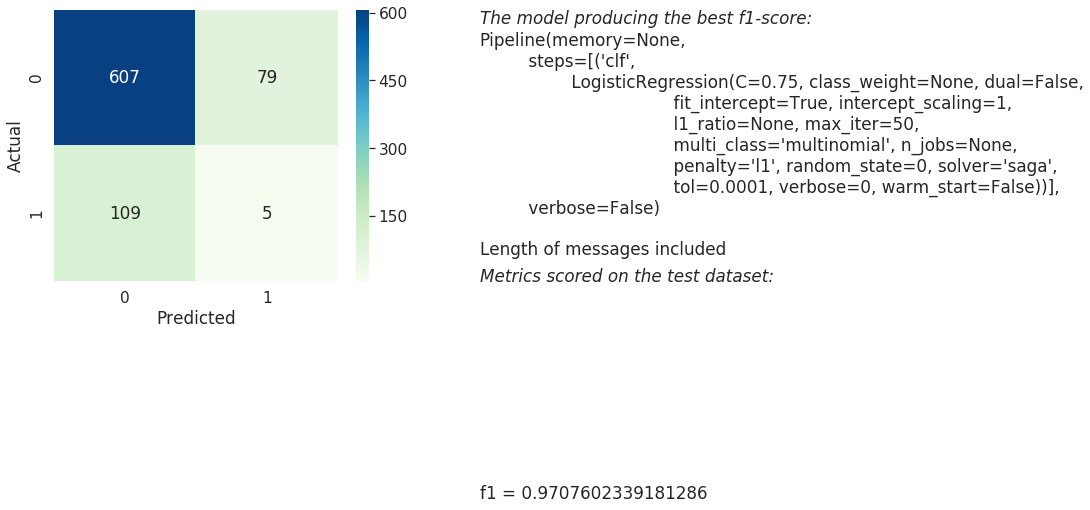

In [65]:
y_true_label = ["0", "1"]
y_pred_labe = ["0", "1"]

data = confusion_matrix(y_true=y_test, y_pred=y_test_best_pred_len)
df_cm = pd.DataFrame(data, columns=np.unique(y_true_label), index = np.unique(y_true_label))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.set(font_scale=1.4)#for label size
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size annot=True, fmt="d"
sns.heatmap(df_cm, cmap="GnBu",annot=True,fmt="d")
plt.subplot(1,2,2)
plt.text(0,0.95,'The model producing the best f1-score:', fontstyle = 'italic')
plt.text(0,0.25,'{}'
      .format(grid_search_LR_len.best_estimator_))
plt.text(0,0.1,'Length of messages included')
plt.text(0,0,'Metrics scored on the test dataset:', fontstyle = 'italic')
plt.text(0,-0.8,'f1 = {}'.format(f1_score_best_LR_len))
plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
plt.savefig('Confusion_matrix_best_LR_with_length.png')

## *Interlude*: PCA analysis 
#### *How to visualise the data*

In [60]:
svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train)

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF0E16']   #   FF7F0E
    #markers = ['o', 's']
    transp = [0.45,0.95]
    markers =  [',', ',']
    fig = plt.figure(figsize=(16,14))    
    ax = fig.add_subplot(1,1,1)
    for l, c, m, t in zip(np.unique(y), colors, markers, transp):
        plt.scatter(
            X[y==l, 0]/max(max(X[:,0]),max(X[:,1])),
            X[y==l, 1]/max(max(X[:,0]),max(X[:,1])),
            c=c, label=l, 
            marker=m,
            alpha = t,
            s=1,
            #facecolor='black'
        )
        ax.set_xbound(lower=-0.1, upper=0.5)
        ax.set_ybound(lower=-0.4, upper=0.4)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

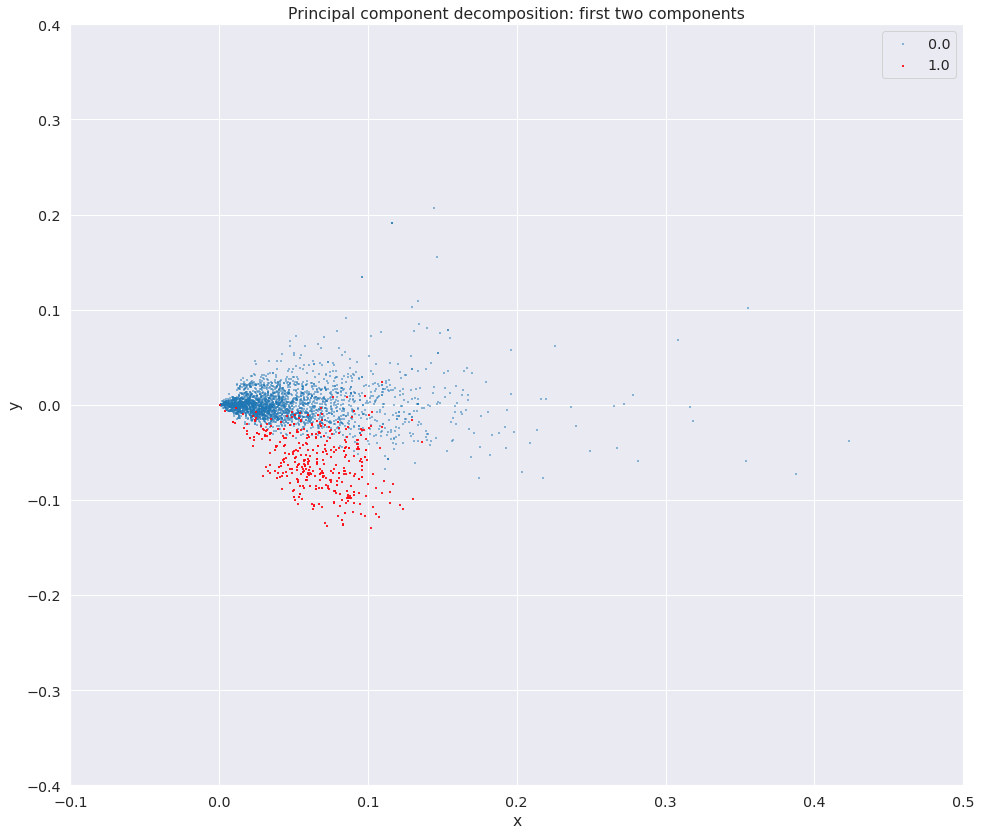

In [61]:
figure= plot_2d_space(X_train_svd, y_train, 'Principal component decomposition: first two components')

In [62]:
svd3 = TruncatedSVD(n_components=3)
X_train_svd3 = svd3.fit_transform(X_train)

In [63]:
def plot_3d_space(X, y,dire,label='Classes'): 
    %matplotlib notebook
    colors = ['#1F77B4', '#FF0E16']   #   FF7F0E
    #markers = ['o', 's']
    transp = [0.35,0.8]
    markers =  [',', ',']
    fig = plt.figure(figsize=(9.5,9.5)) 
    ax = fig.add_subplot(1,1,1)
    ax = fig.gca( projection='3d')
    for l, c, m, t,lab in zip(np.unique(y), colors, markers, transp,['0','1']):
        #Axes3D.scatter(
        ax.scatter(
            X[y==l, 0]/max(max(X[:,0]),max(X[:,1]),max(X[:,2])),
            X[y==l, 1]/max(max(X[:,0]),max(X[:,1]),max(X[:,2])),
            X[y==l, 2]/max(max(X[:,0]),max(X[:,1]),max(X[:,2])),
            zdir= dire,
            c=c, 
            label=lab, 
            alpha = t,
            s=1,
        )
        ax.set_xbound(lower=-0.2, upper=0.5)
        ax.set_ybound(lower=-0.15, upper=0.55)
        ax.set_zbound(lower=-0.35, upper=0.35)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')    
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

<IPython.core.display.Javascript object>


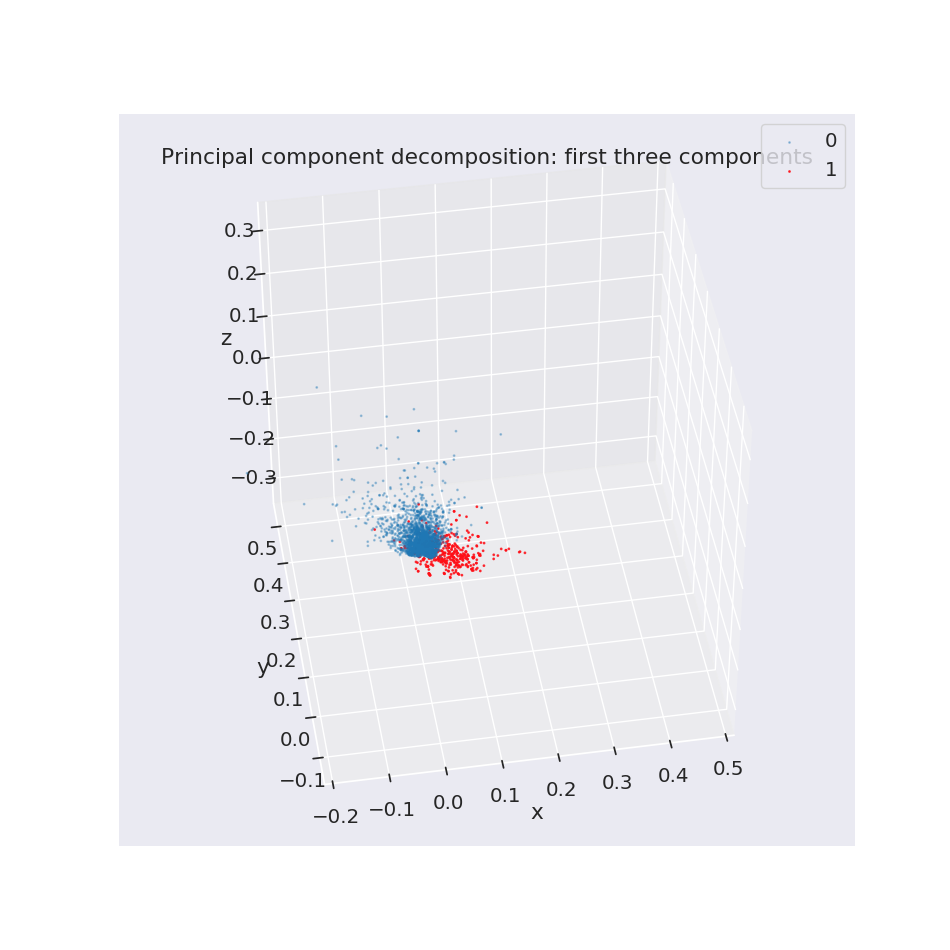

In [64]:
%matplotlib notebook
figure= plot_3d_space(X_train_svd3, y_train,  'x','Principal component decomposition: first three components')

<IPython.core.display.Javascript object>


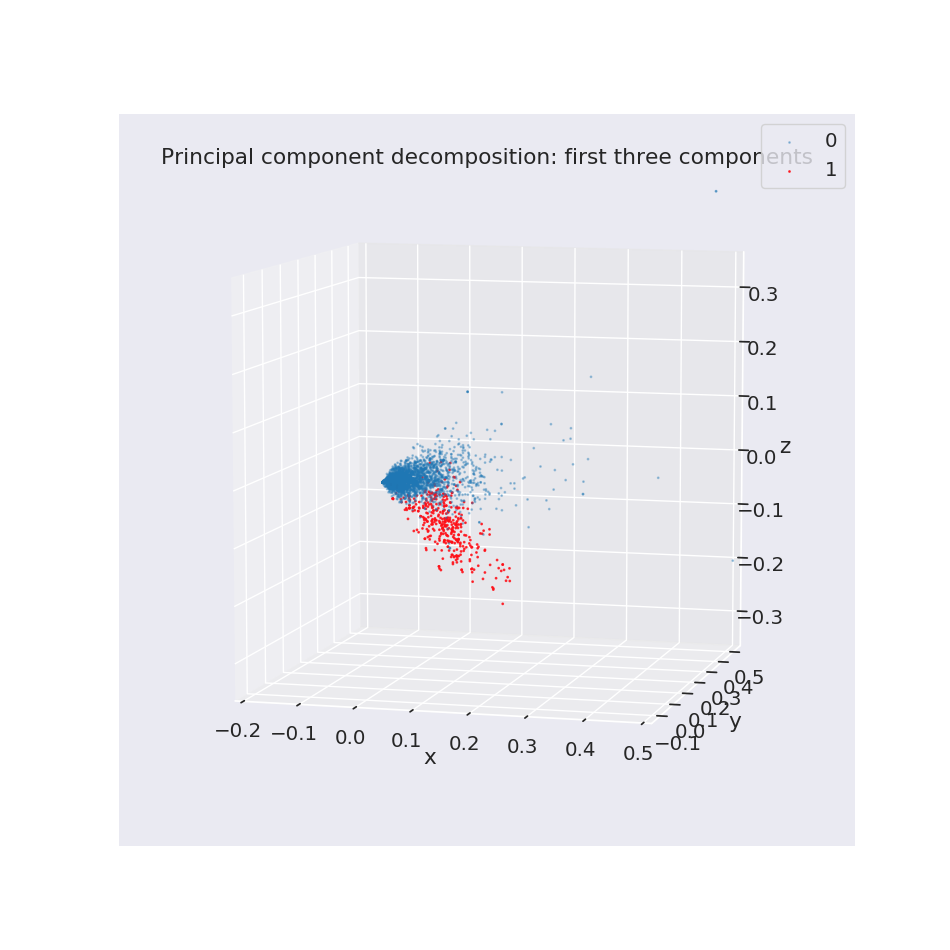

In [35]:
figure= plot_3d_space(X_train_svd3, y_train,  'y','Principal component decomposition: first three components')

<IPython.core.display.Javascript object>


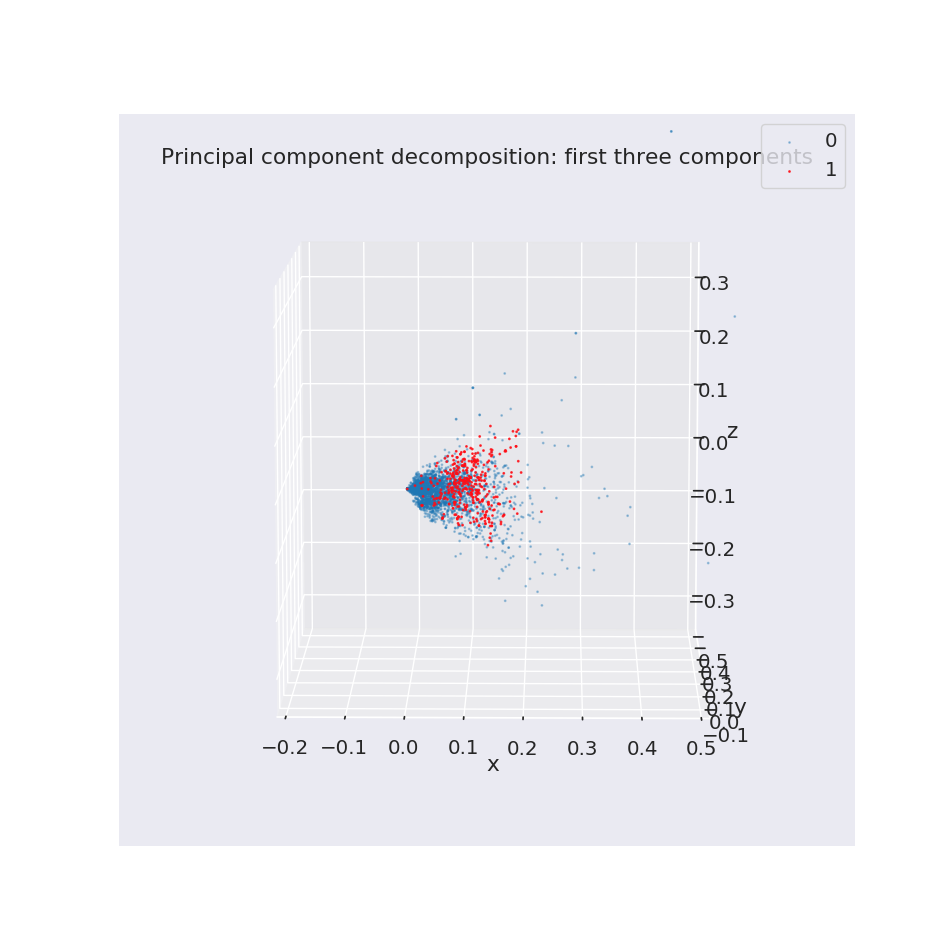

In [37]:
figure= plot_3d_space(X_train_svd3, y_train,  'z','Principal component decomposition: first three components')

## 4 - Classification Logistic Regression combined with Re-Sampling

In [65]:
def train_model( feature_vector_train, label, feature_vector_valid,valid_y):
    #Return the f1 Score
    # fit the training dataset on the classifier
    best_LR.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = best_LR.predict(feature_vector_valid)    

    return metrics.f1_score(valid_y,predictions)

f1_scores=dict({})

 #logistic regression
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_train,y_train,test_size= 0.2,stratify = y_train)


ros = RandomOverSampler(random_state=777) #over
sm = SMOTE(random_state=777, ratio = 1.0) #over
ad = ADASYN(random_state=777, ratio = 1.0) #over
bsm = BorderlineSMOTE() #over
rus = RandomUnderSampler(random_state=0, replacement=True) #under
tl = TomekLinks() #under

resampler = dict({'ros':ros,'sm':sm,'ad':ad,'bsm':bsm,'rus':rus,'tl':tl})

for name, method in resampler.items():
    X_res,y_res = method.fit_sample(X_train_res,y_train_res)
    f1= train_model(X_res,y_res,X_val_res,y_val_res)
    f1_scores['{}'.format(name)]= f1
    print('Method {}:{}'.format(name,f1_scores['{}'.format(name)]))
print(f1_scores.items())

Method ros:0.9433962264150942
Method sm:0.9358974358974359
Method ad:0.9358974358974359
Method bsm:0.9220779220779222
Method rus:0.9285714285714286
Method tl:0.9210526315789475
dict_items([('ros', 0.9433962264150942), ('sm', 0.9358974358974359), ('ad', 0.9358974358974359), ('bsm', 0.9220779220779222), ('rus', 0.9285714285714286), ('tl', 0.9210526315789475)])


#### How they perform on the test set?

As two methods seems to have pretty similar score, let's have a look at how both perform on a never seen before data set (test set).

In [66]:
best_resampler = dict({'ros-over':ros,'sm-over':sm,'rus-under':rus})

In [67]:
f1_scores_test=dict({})
for name, method in best_resampler.items():
    X_res,y_res = method.fit_sample(X_train,y_train)
    f1= train_model(X_res,y_res,X_test,y_test)
    f1_scores_test['{}'.format(name)]= f1
    print('Method {} on test set, f1 is :{}'.format(name,f1_scores_test['{}'.format(name)]))


Method ros-over on test set, f1 is :0.9300411522633745
Method sm-over on test set, f1 is :0.925
Method rus-under on test set, f1 is :0.9133858267716536


In [68]:
np.size(y_res==1) == np.size(y_res == 0)

True

In [69]:
np.size(y_res==1)

818

In [70]:
def plot_2d_resample(X, y, dic,label='Classes'):   
    colors = ['#1F77B4', '#FF0E16']   #   FF7F0E
    #markers = ['o', 's']
    transp = [0.35,0.35]
    markers =  [',', ',']
    X_svd = svd.fit_transform(X)
    fig = plt.figure(figsize=(16,14))
    plt.suptitle(label)
    plt.subplot(2,2,1)
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.subplots_adjust( wspace=0.4, hspace=0.4)
    for l, c, m, t in zip(np.unique(y), colors, markers, transp):
        plt.scatter(
            X_svd[y==l, 0]/max(max(X_svd[:,0]),max(X_svd[:,1])),
            X_svd[y==l, 1]/max(max(X_svd[:,0]),max(X_svd[:,1])),
            c=c, label=l, 
            marker=m,
            alpha = t,
            s=1,
            #facecolor='black'
        )
        plt.xlim(-0.1, 0.7)
        plt.ylim(-0.4, 0.4)
        plt.xlabel('x')
        plt.ylabel('y')
    plt.title('No Re-sample')
    plt.legend(loc='upper right')
    i=1
    for name,method in dic:
        i+=1
        plt.subplot(2,2,i)
        plt.subplots_adjust( wspace=0.4, hspace=0.4)
        plt.gca().set_aspect('equal', adjustable='box')
        X_res,y_res = method.fit_sample(X,y)
        X_res_svd = svd.fit_transform(X_res)
        for l, c, m, t in zip(np.unique(y), colors, markers, transp):
            plt.scatter(
                X_res_svd[y_res==l, 0]/max(max(X_res_svd[:,0]),max(X_res_svd[:,1])),
                X_res_svd[y_res==l, 1]/max(max(X_res_svd[:,0]),max(X_res_svd[:,1])),
                c=c, label=l, 
                marker=m,
                alpha = t,
                s=1,
                #facecolor='black'
            )
            plt.xlim(-0.1, 0.7)
            plt.ylim(-0.4, 0.4)
            plt.xlabel('x')
            plt.ylabel('y')
        plt.title('{}'.format(name))
        plt.legend(loc='upper right')
    plt.show()

<IPython.core.display.Javascript object>


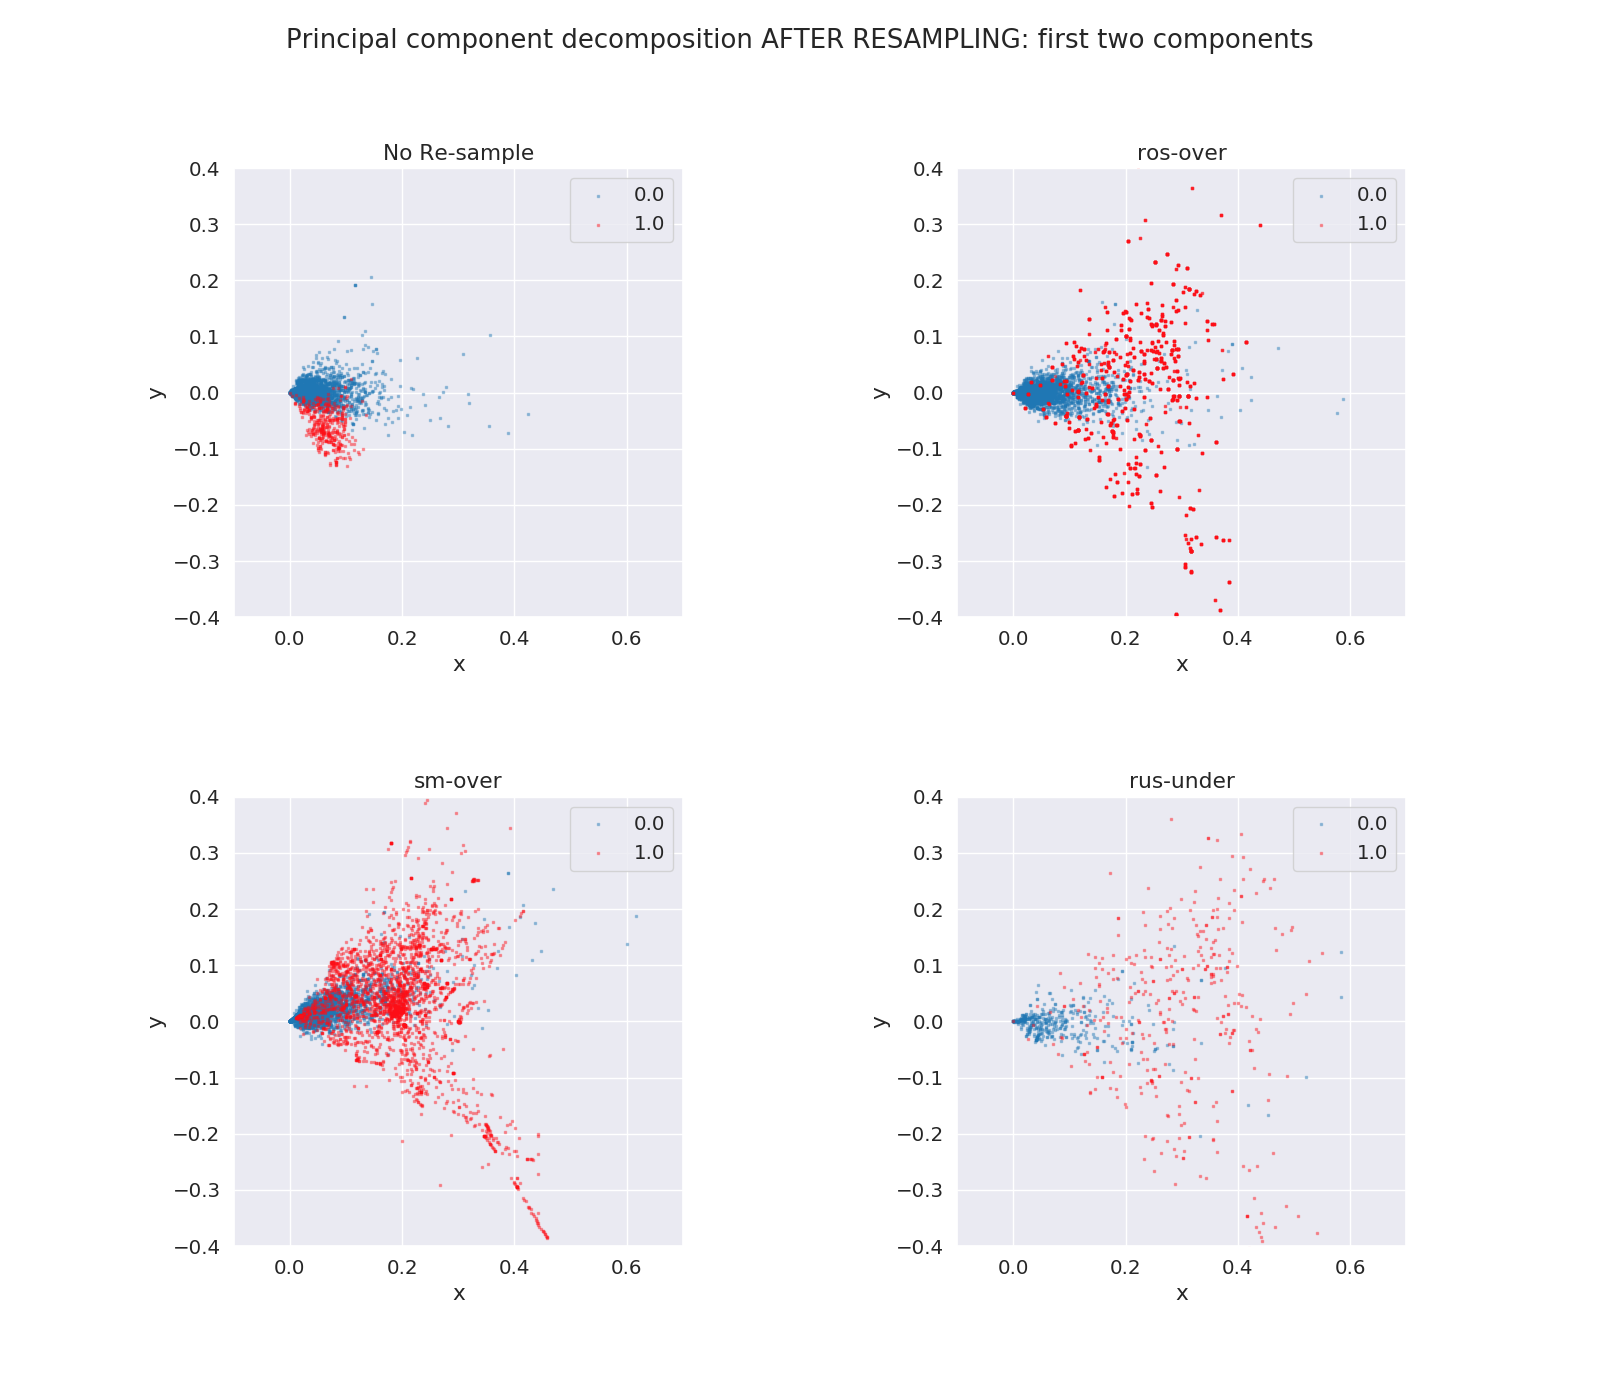

In [71]:
figure= plot_2d_resample(X_train, y_train,best_resampler.items(), 'Principal component decomposition AFTER RESAMPLING: first two components')

<IPython.core.display.Javascript object>


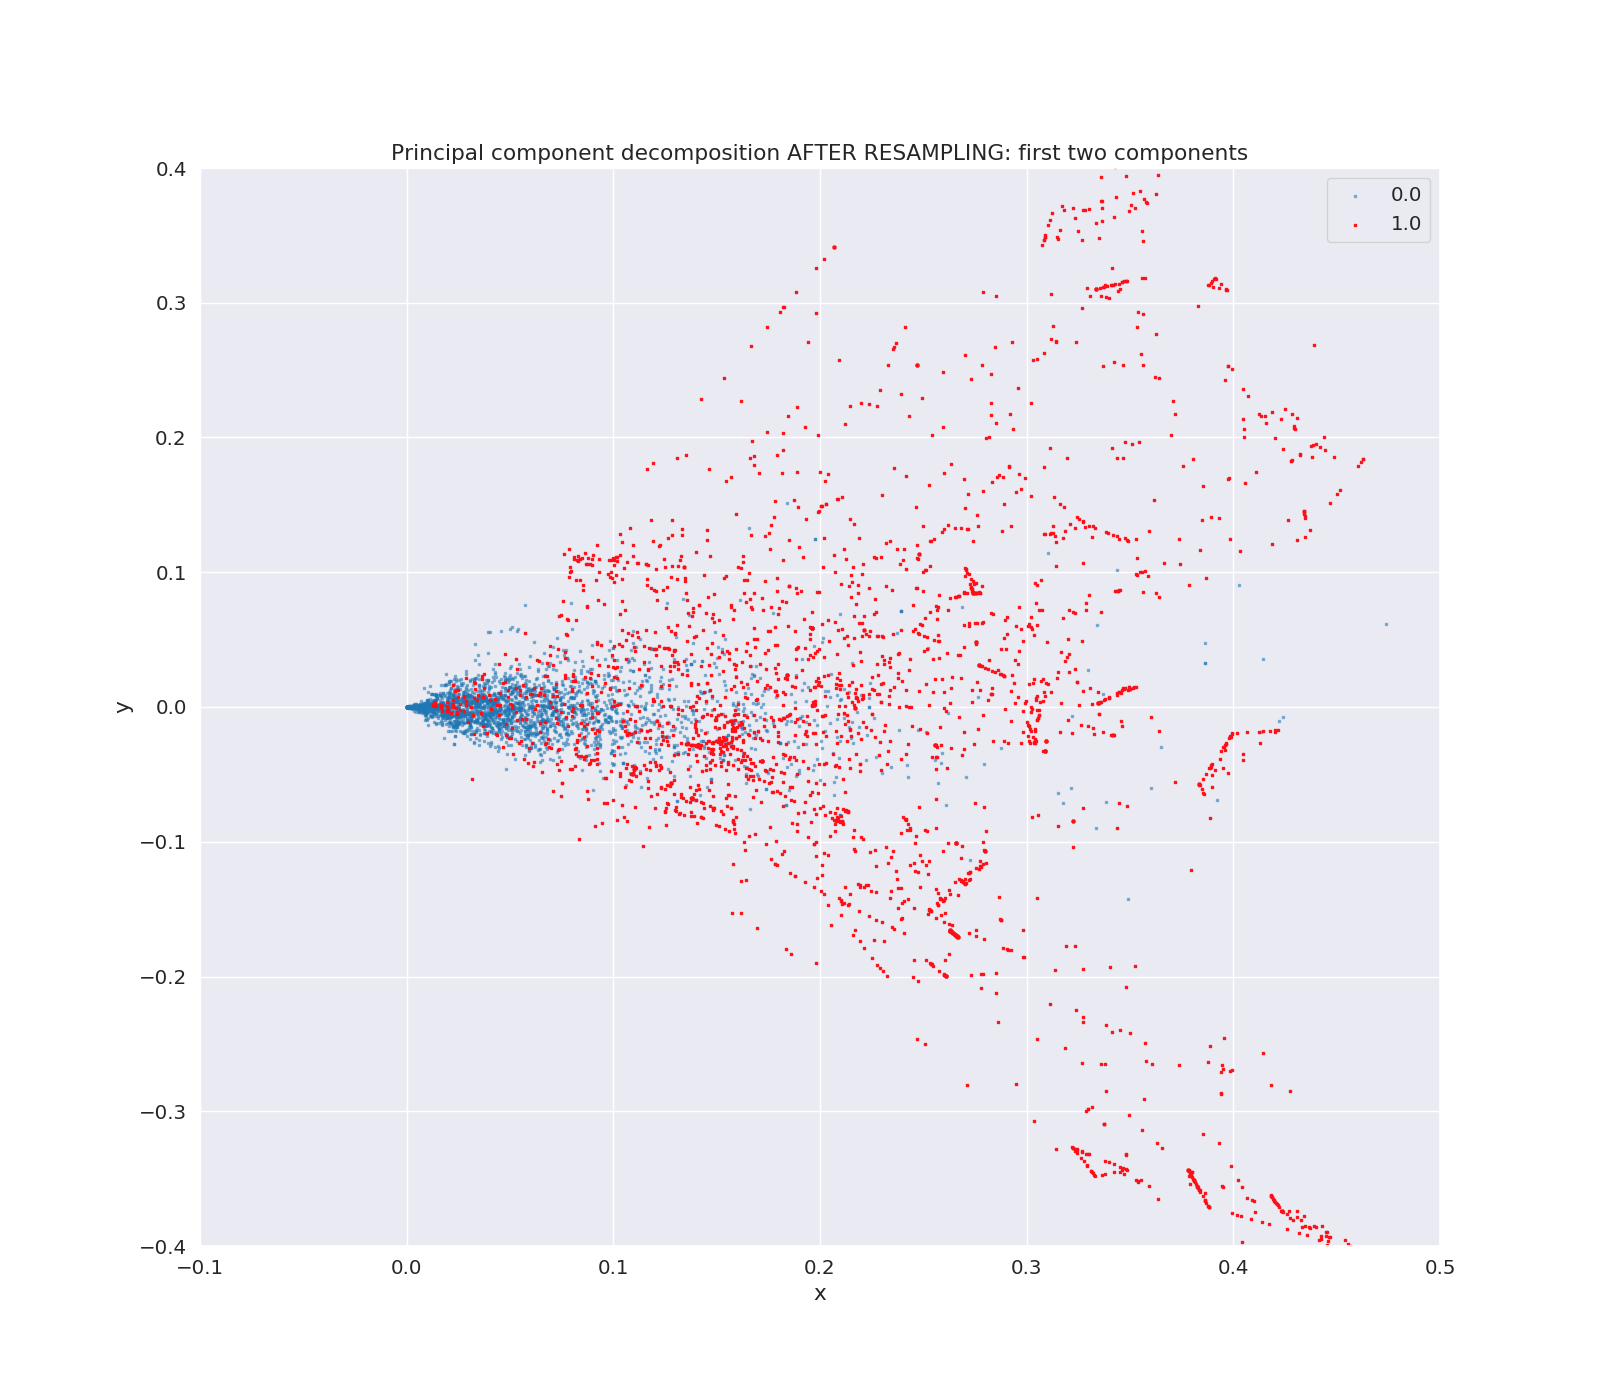

In [72]:
X_res,y_res = bsm.fit_sample(X_train,y_train)
X_res_svd = svd.fit_transform(X_res)
figure= plot_2d_space(X_res_svd, y_res, 'Principal component decomposition AFTER RESAMPLING: first two components')

<IPython.core.display.Javascript object>


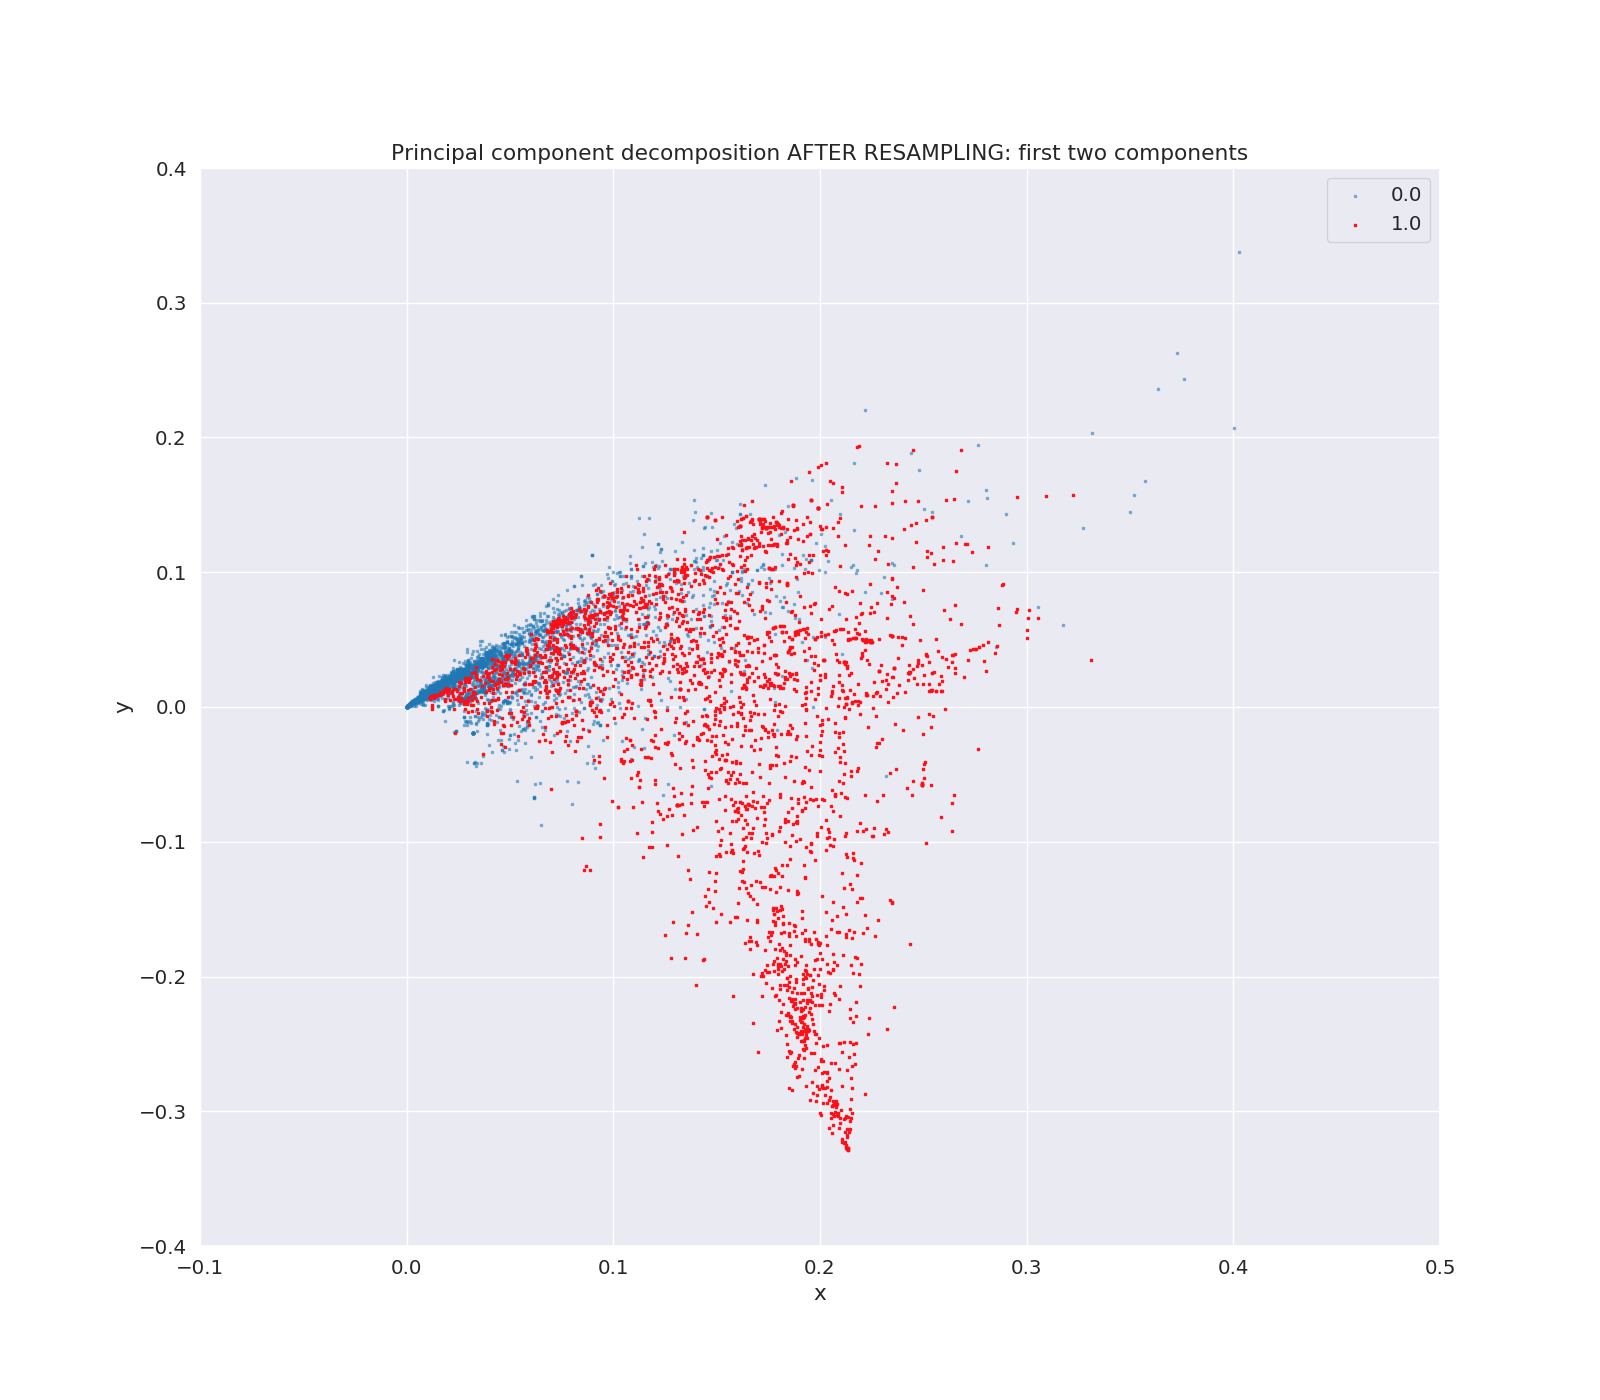

In [73]:
X_res,y_res = ad.fit_sample(X_train,y_train)
X_res_svd = svd.fit_transform(X_res)
figure= plot_2d_space(X_res_svd, y_res, 'Principal component decomposition AFTER RESAMPLING: first two components')

# 5 - Classification using Neural-Network (Keras)

In this following we change approach and consider a different methodology in order to address our problem. Instead of focusing on capturing the best parameters though, we want to explore what the effect of these are on our new model.

The model's parameters that we will examine are:
- Threshold for class decision 
- Regularization
- Dropout
- Size of the hidden layers



#### Different Threshold 

Given one sample with a certain probability $p$ predicted by the model, by deafult the Keras classifier would classify it as 1 (positive) if $p>0.5$, 0 (negative) otherwise. When dealing with unbalanced dateset though, it might be appropriate to try different values for such threshold. Heuristically, for lower values of this threshold we are trying to help the model to classify more sample as in the weak class 1. This might be of extreme importance when dealing with experiments when high recall performance is required (e.g. cancer prediction). Lower values of  the threshold increase the recall performance of out system.

In [32]:
def pred_round(x,thr):
    '''
    INPUT:  x, the vector of predictions produced by the NN learning
        thr, the threshold we use to classify the predictions into 0 or 1 class.
    OUTPUT: a vector containing 0 and 1, the labels of the messages predicted

    For classify a message positive with 1 if x > thr.
    '''
    if 0<thr<1:
        return 1*(x >thr)

#### Metrics
As done before, we want to check the quality of our predictions by means of the metrics
- f1
- recall
- precision
- MCC
which have been already introduced. In order to make a meaningful use of such metrics in Keras, we need to pass them using a callback. The reason of such quibble is that Keras evaluates whatever metrics we pass into as metric argument after each batch computation. This might in turn provide ambiguous if not misleading information about the learning and the quality of it.

In [33]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.val_MCC = []
        self.conf_mat = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = pred_round(self.model.predict(self.validation_data[0]), threshold)
        val_targ = self.validation_data[1]
        _val_precision, _val_recall, _val_f1, dummy = precision_recall_fscore_support(val_targ, val_predict,
                                                                                      beta = 1.0,average = 'binary')
        _val_MCC = matthews_corrcoef(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        self.val_MCC.append(_val_MCC)
    
    def on_train_end(self, logs={}):
        val_predict = pred_round(self.model.predict(self.validation_data[0]), threshold)
        val_targ = self.validation_data[1]
        self.conf_mat = confusion_matrix(y_true=val_targ, y_pred=val_predict)

#### The model

Another distinctive point w.r.t. the previous type of analysis is that we won't use this time an automated GridsearcCV type of function. This is mainly due to the fact that the analysis we want to perform require a certain type of flexibility which is not easily retreived using the sklearn wrapper.

In the following we collect therefore all the parameters we need and we will change some of them in future parts of this 
file.

In [34]:
def create_model(optimizer, drop, init, l_hidden, n_hidden, reg_val):
        model = Sequential()
        model.add(Dense(n_hidden, activation = 'sigmoid', input_shape=(N_FEATURES,) , kernel_initializer=init,
                            kernel_regularizer=keras.regularizers.l2(reg_val)))
        for i in range(l_hidden):
            model.add(Dropout(drop))
            model.add(Dense(n_hidden, activation = 'sigmoid', kernel_initializer=init,
                            kernel_regularizer=keras.regularizers.l2(reg_val)))
        if hidden != 0:
            model.add(Dropout(drop))
            
        model.add(Dense(1,activation = 'sigmoid', kernel_initializer=init,
                        kernel_regularizer=keras.regularizers.l2(reg_val)))
        model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                        ) 
        model.summary()
        return model

#### Parameters

In [35]:
metrics = Metrics()                             # the metrics defined in the previous class
OPTIMIZER = Adadelta()                          # the method used to minimise the cost function
N_FEATURES = X_train.shape[1]                   # the number of features
VERBOSE = 0
initial_points='uniform'                        # We initialise the coefficients of our neural networl by default 
                                                # randomly picking them from a uniform distribution.

cv_repetitions = 1 #5                           # numner of times we go through the croos-validation dataset
EPOCHS = 150                                   # number of times the algorithm goes through the dataset.
BATCH_SIZE = 256                                # the number of point used to compute the derivatives of the cost function
                                                # and so before the system updates the coefficients

In [36]:
hidden = 2                                      # number of extra hidden layers (excluded the intial one, there by default)

dropout = 0.3                                    # percentage of nodes that are randomly excluded while running the algorithm.
regular_val = 0.001                               # regularization value in the cost function. 
# To prevent overfitting this parameters should be set as: 'dropout = 0.3' and 'regular_val = 0.001'


# The following function return the vector containing the threshold values. If both regularization and dropout are null,
# we set by default the threshold to the unique value of 0.5. This is because under those assumption, the model will 
# overfit quite easily and we won't be interested in exploring in fact the different metrics. This speeds up a little
# the algorithm, preventing it from looping over several threshold when not needed.

def thr_values(reg_val, drop):
    if (reg_val == 0 and drop == 0):
        return [0.5]
    else:
        return [0.15,0.25,0.5,0.75]
    

# The following function simply return the vector containing different values for the number of neurons per each layer.

def neurons(n):
    if n == 0:
        return [1500]
    elif n == 1:
        return [100,500,750,1000]
    elif n == 2:
        return [100,250,300,450]

N_HIDDEN = neurons(hidden)              # number of neurons per each layer. 
thresholds = thr_values(regular_val,dropout)   #threshold values
thr_columns = ['{}'.format(t) for t in thresholds]

In [37]:
# A set of empty dataframe which will contain the metrics for different thrshold values.
f1_df = pd.DataFrame()
recall_df = pd.DataFrame()
precision_df = pd.DataFrame()
MCC_df = pd.DataFrame()

It follows the main part of the code. It's wrapped in a form of wrapped for loop. The external loop is on the number of neurons we prescribe for our model. For each of such value we will analyse the behaviour of the model w.r.t. different threshold decision values.

In [38]:
def plotting(drop, reg_val,l_hidden,n_hid,cost_fn, cost_fn_cv,f1s , recalls, precisions, MCCs, ep):
    thresholds = thr_values(reg_val, drop)

    if (drop == 0 and reg_val == 0):
        fig = plt.figure(figsize=(30,16))
        fig.suptitle('Losses and cv_metrics.\n Layers: {}, Neurons: {}, Dropout: {}, Reg: {}'.format(l_hidden+1,n_hid,
                                                                                                     drop,reg_val))
        fig.tight_layout()
        plt.subplots_adjust( wspace=0.2, hspace=0.2)

        # For each value of neurons in the layer we considered we plot the loss function (obersve it does not depend on the
        # threshold values, therefore we plot the averege of the loss over repetition on cv and different thresholds.)
        plt.subplot(1,1,1)
        plt.plot(cost_fn)
        plt.plot(cost_fn_cv)
        plt.title('num neurons = {} '.format(n_hid),fontsize='small')
        plt.ylabel('Loss',fontsize='small')
        plt.xlabel('Epoch',fontsize='small')
        plt.legend(['Train', 'Cross Validation'], loc='upper right')
        fig.savefig('OVER_FITTING: Loss_metrics_Layers_{}_neur_{}_reg_{}_DROPOUT_{}_different_thrs_EOPCHS_{}.png'.format(l_hidden+1,
                                                                                        n_hid,reg_val,drop,ep))
    else:
        fig = plt.figure(figsize=(30,16))
        fig.suptitle('Losses and cv_metrics.\n Layers: {}, Neurons: {}, Dropout: {}, Reg: {}'.format(l_hidden+1,n_hid,
                                                                                                     drop,reg_val))
        fig.tight_layout()
        plt.subplots_adjust( wspace=0.2, hspace=0.2)

        # For each value of neurons in the layer we considered we plot the loss function (obersve it does not depend on the
        # threshold values, therefore we plot the averege of the loss over repetition on cv and different thresholds.)
        plt.subplot(2,3,1)
        plt.plot(cost_fn)
        plt.plot(cost_fn_cv)
        plt.title('num neurons = {} '.format(n_hid),fontsize='small')
        plt.ylabel('Loss',fontsize='small')
        plt.xlabel('Epoch',fontsize='small')
        plt.legend(['Train', 'Cross Validation'], loc='upper right')

        # Now we plot the metrics in the left boxes.
        for i in range(len(thresholds)):
            plt.subplot(2,3,i+2)
            plt.subplots_adjust( wspace=0.2, hspace=0.2)
            plt.plot(f1s[i])
            plt.plot(recalls[i])
            plt.plot(precisions[i])
            plt.plot(MCCs[i])
            plt.title('Threshold = {} '.format(thresholds[i]),fontsize='small')
            plt.ylabel('Metrics',fontsize='small')
            plt.xlabel('Epoch',fontsize='small')
            plt.legend(['f1', 'recall', 'precision', 'MCC'], loc='upper right')
        plt.show()        
        
        # And save everything
        testing = len(cost_fn)
        if testing < 10:
            fig.savefig('TEST_Loss_metrics_Layers_{}_neur_{}_reg_{}_DROPOUT_{}_different_thrs_EPOCHS_{}.png'.format(l_hidden+1,
                                                                                        n_hid,reg_val,drop,ep))
        else:
            fig.savefig('Loss_metrics_Layers_{}_neur_{}_reg_{}_DROPOUT_{}_different_thrs_EPOCHS_{}.png'.format(l_hidden+1,
                                                                                        n_hid,reg_val,drop,ep))

#### Fitting the model and cv results

In [39]:
# The external loop is over the number of neurons contained in each layer.
for n_hidden in N_HIDDEN:
    
    # We initialase all the variables that we need. 
    losses=0
    losses_cv = 0
    f1_scores =[]
    recall_scores = []
    precision_scores = []
    MCC_scores = []
    avg_f1 = []
    avg_recall = []
    avg_precision = []
    avg_MCC = []
    t0 = time()

    '''
    # We create the model. 
    model = create_model(optimizer= OPTIMIZER, drop = dropout , init = initial_points, l_hidden = hidden, 
                         n_hidden = n_hidden, reg_val = regular_val)
    '''
    # So we loop over different values of threshold.
    for threshold in thresholds:
        
        # We create the model. 
        model = create_model(optimizer= OPTIMIZER, drop = dropout , init = initial_points, l_hidden = hidden, 
                         n_hidden = n_hidden, reg_val = regular_val)

        f1_cv_scores = np.zeros(EPOCHS)
        recall_cv_scores = np.zeros(EPOCHS)
        precision_cv_scores = np.zeros(EPOCHS)
        MCC_cv_scores = np.zeros(EPOCHS)
        loss_train_scores = np.zeros(EPOCHS)
        loss_cv_scores = np.zeros(EPOCHS)
        
        # As we don't want to give up on a averaging approach on the cross-validation part, we create in the following 
        # a for loop which allows to average the loss values and the metrics over several slices of the train set.
        # Note that instead of using a KFold approach we preferred, given the unbalnced dataset, the data be consistent
        # with the number of elements in the two classes, therefore the instance 'stratify = y_train'.
        i=0
        for i in range(cv_repetitions):
            X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train,y_train,test_size= 0.2,
                                                                          stratify = y_train)
            history = model.fit( x= X_train_NN, y= y_train_NN,
                                batch_size = BATCH_SIZE,
                                validation_data = (X_val_NN,y_val_NN),
                                epochs = EPOCHS,
                                verbose = VERBOSE,
                                callbacks = [metrics],
                                shuffle = False
                                )
            loss_train_scores += history.history['loss']
            loss_cv_scores   += history.history['val_loss']
            f1_cv_scores += metrics.val_f1s
            recall_cv_scores += metrics.val_recalls
            precision_cv_scores += metrics.val_precisions
            MCC_cv_scores += metrics.val_MCC
            i+=1
        
        # So we average over the number of cv-repetions:
        loss_train_scores = loss_train_scores/cv_repetitions
        loss_cv_scores   = loss_cv_scores/cv_repetitions
        f1_cv_scores     = f1_cv_scores /cv_repetitions
        recall_cv_scores = recall_cv_scores/cv_repetitions
        precision_cv_scores = precision_cv_scores/cv_repetitions
        MCC_cv_scores = MCC_cv_scores/cv_repetitions
        
        # From the plots of the different metrics versus the number of epochs, we observe a certain variability of 
        # such values. In order to keep meaningful values which can assert the quality of the different models, we consider
        # the values of the averages on the metrics over the last quarter of the epochs. 
        avg_f1.append(np.mean(f1_cv_scores[-int(np.round(EPOCHS/4)):]))
        avg_recall.append(np.mean(recall_cv_scores[-int(np.round(EPOCHS/4)):]))
        avg_precision.append(np.mean(precision_cv_scores[-int(np.round(EPOCHS/4)):]))
        avg_MCC.append(np.mean(MCC_scores[-int(np.round(EPOCHS/4)):]))
        
        #The following will be used for plotting.
        losses += loss_train_scores
        losses_cv += loss_cv_scores
        f1_scores.append(f1_cv_scores)
        recall_scores.append(recall_cv_scores)
        precision_scores.append(precision_cv_scores)
        MCC_scores.append(MCC_cv_scores)
    
    #Out of the loop over the threshold, we save our results in the following dataframes.
    f1_temp_df  = pd.DataFrame([avg_f1], columns = thr_columns)
    f1_df = f1_df.append(f1_temp_df, ignore_index = True)
    
    recall_temp_df  = pd.DataFrame([avg_recall], columns = thr_columns)
    recall_df = recall_df.append(recall_temp_df, ignore_index = True)
    
    precision_temp_df  = pd.DataFrame([avg_precision], columns = thr_columns)
    precision_df = precision_df.append(precision_temp_df, ignore_index = True)
    
    MCC_temp_df  = pd.DataFrame([avg_MCC], columns = thr_columns)
    MCC_df = MCC_df.append(MCC_temp_df, ignore_index = True)

    losses = losses/len(thresholds)
    losses_cv = losses_cv/len(thresholds)
    

    # Print the result:
    # With no dropout and regularization we observe overfitting.
    figure = plotting(dropout,regular_val,hidden,n_hidden,losses,losses_cv,f1_scores ,recall_scores,
                      precision_scores,MCC_scores,EPOCHS)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               868400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

KeyboardInterrupt: 

#### Best f1 score

In [44]:
print()
print('f1 scores across different thresholds and different number of neurons in the hidden layers:\n {}'.format(f1_df))
print()
print('best f1 for threshold set to {} and {} neurons in each hidden layer is: \n {}'.format(f1_df.max().idxmax(), 
            N_HIDDEN[f1_df[f1_df.max().idxmax()].idxmax()], f1_df[f1_df.max().idxmax()][f1_df[f1_df.max().idxmax()].idxmax()] ) )
f1_best_thr = float(f1_df.max().idxmax())
f1_best_n_hidden = N_HIDDEN[f1_df[f1_df.max().idxmax()].idxmax()]


f1 scores across different thresholds and different number of neurons in the hidden layers:
        0.15      0.25       0.5      0.75
0  0.931642  0.926585  0.957241  0.900286
1  0.974896  0.924458  0.892381  0.857225

best f1 for threshold set to 0.15 and 450 neurons in each hidden layer is: 
 0.9748959369059687


#### Best recall score

In [45]:
print()
print('recall scores across different thresholds and different number of neurons in the hidden layers:\n {}'.format(recall_df))
print()
print('best recall for threshold set to {} and {} neurons in each hidden layer is: \n {}'.format(recall_df.max().idxmax(), 
            N_HIDDEN[recall_df[recall_df.max().idxmax()].idxmax()], recall_df[recall_df.max().idxmax()][recall_df[recall_df.max().idxmax()].idxmax()] ) )


recall scores across different thresholds and different number of neurons in the hidden layers:
        0.15      0.25       0.5      0.75
0  0.895349  0.870869  0.917993  0.818849
1  0.951040  0.889535  0.815177  0.759180

best recall for threshold set to 0.15 and 450 neurons in each hidden layer is: 
 0.9510403916768668


#### Best precision score

In [46]:
print()
print('precision scores across different thresholds and different number of neurons in the hidden layers:\n {}'.format(precision_df))
print()
print('best precision for threshold set to {} and {} neurons in each hidden layer is: \n {}'.format(precision_df.max().idxmax(), 
    N_HIDDEN[precision_df[precision_df.max().idxmax()].idxmax()], precision_df[precision_df.max().idxmax()][precision_df[precision_df.max().idxmax()].idxmax()] ) )


precision scores across different thresholds and different number of neurons in the hidden layers:
        0.15      0.25       0.5    0.75
0  0.971248  0.989954  1.000000  1.0000
1  1.000000  0.962294  0.985931  0.9849

best precision for threshold set to 0.15 and 450 neurons in each hidden layer is: 
 1.0


#### Best MCC score

In [47]:
print()
print('MCC scores across different thresholds and different number of neurons in the hidden layers:\n {}'.format(MCC_df))
print()
print('best MCC for threshold set to {} and {} neurons in each hidden layer is: \n {}'.format(MCC_df.max().idxmax(), 
            N_HIDDEN[MCC_df[MCC_df.max().idxmax()].idxmax()], MCC_df[MCC_df.max().idxmax()][MCC_df[MCC_df.max().idxmax()].idxmax()] ) )



MCC scores across different thresholds and different number of neurons in the hidden layers:
    0.15      0.25       0.5      0.75
0   NaN  0.551540  0.571792  0.553733
1   NaN  0.784756  0.717325  0.675466

best MCC for threshold set to 0.25 and 450 neurons in each hidden layer is: 
 0.7847559636374256


#### The best model. How it perform on test set?

Let's use the f1 score as reference. It follows that the best parameters for our model are the following:

In [40]:
best_model = create_model(optimizer= OPTIMIZER, drop = dropout , init = initial_points, l_hidden = hidden, 
                         n_hidden = f1_best_n_hidden, reg_val = regular_val)

NameError: name 'f1_best_n_hidden' is not defined

In [41]:
best_model.fit( x= X_train, y= y_train,
                                batch_size = BATCH_SIZE,
                                epochs = EPOCHS
                                )

NameError: name 'best_model' is not defined

In [50]:
predictions = best_model.predict(X_test)
test_predict = pred_round(predictions, f1_best_thr)
#test_targ = y_test

test_precision, test_recall, test_f1, test_dummy = precision_recall_fscore_support( y_test, test_predict,beta = 1.0,average = 'binary')

print()
print('Metrics for the test set: \nNum layers={}, neurons = {}, dropout={}, regularization={} \nprecision, recall, f1= {},{},{} '
      .format(hidden+1, f1_best_n_hidden,dropout,regular_val,np.around(test_precision,5), 
              np.around(test_recall,5), np.around(test_f1,5)))



Metrics for the test set: 
Num layers=3, neurons = 450, dropout=0.3, regularization=0.001 
precision, recall, f1= 0.90826,0.95192,0.92958 


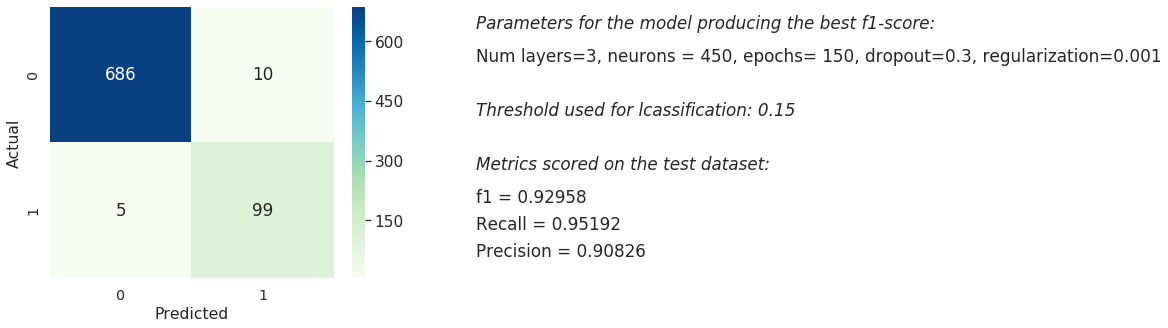

In [51]:
y_true = ["0", "1"]
y_pred = ["0", "1"]
data = confusion_matrix(y_true=y_test, y_pred=test_predict)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.set(font_scale=1.4)#for label size
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size annot=True, fmt="d"
sns.heatmap(df_cm, cmap="GnBu",annot=True,fmt="d")
plt.subplot(1,2,2)
plt.text(0,0.92,'Parameters for the model producing the best f1-score:', fontstyle = 'italic')
plt.text(0,0.8,'Num layers={}, neurons = {}, epochs= {}, dropout={}, regularization={}'
      .format(hidden+1, f1_best_n_hidden,EPOCHS, dropout,regular_val))
plt.text(0,0.6,'Threshold used for lcassification: {}'.format(f1_best_thr), fontstyle = 'italic')
plt.text(0,0.4,'Metrics scored on the test dataset:', fontstyle = 'italic')
plt.text(0,0.08,'Precision = {}'.format(np.around(test_precision,5)))
plt.text(0,0.18,'Recall = {}'.format(np.around(test_recall,5)))
plt.text(0,0.28,'f1 = {}'.format(np.around(test_f1,5)))
plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
plt.savefig('Confusion_matrix_layers_{}_neurons_{}_epochs_{}_drop_{}_reg_{}.png'.format(
            hidden+1, f1_best_n_hidden,EPOCHS, dropout,regular_val,np.around(test_precision,5), 
              np.around(test_recall,5), np.around(test_f1,5)))

# Conclusion:

## Logistic regression:

The first attempt we tried was using a simple logistic regression classifier. At first we considered only the features coming from the text after the vvectorization step. The best f1 score registered was $0.9371276135959417$ for the following model:<br>
> ' LogisticRegression(C=0.9, class_weight=None, dual=False,fit_intercept=True, intercept_scaling=1,l1_ratio=None, max_iter=50, multi_class='multinomial', n_jobs=None, penalty='l1', random_state=0, solver='saga', tol=0.0001, verbose=0, warm_start=False)'

We also compared the f1 metric with the Matthews correlation coefficient, to discover that they both provide the same model. In order to improve this result, we tried to work on our dataset. 

The first attempt in this respect was to include in the features also the length of the messages, but the metrics values on the cv set came out to be less favourable, with a f1 score value of $0.920$.

After, we tried a different strategy and worked on the size of our dataset and on the distribution of the two classes. As pointed out at the beginning, in this analysis we are dealing with an unbalanced dataset and so a natural question is to ask if there are ways to compensate the skewness. After performing the vectorization, our text has been converted to a list of numerical vectors where that points which are close in this $n-$ dimensional space should also supposed to be closed in the natural language in which the text was written. Under this assumption, one can think to add to the original dataset some artificial points (messages) with the aim of creating a new balanced dataset, and this can be done using several resamplig methods. We explored some of them in section 4 using the same model which camed out to be the best model for the original dataset, where the length of the messages was not included in the features set, and we obtained the f1 score of $0.9434$ on cv when using RandomOverSampler. It is worth to note that, despite a positive result, the resampling methodology is not really realiable and should be used really cautiously. 

## Neural Networks:

If the following we have gathered the plots produced when running the algorithm for different number of hidden layers and different values of neurons for each layer. Summing up, we can see how this last approach performs bettern than the simple logistic regressor. In particular we register higher values for  the metrics scores for all the models compared with the logistic regressor seen in the previous section. <br>  <br>Interestingly, even if the f1 value registered on the cv set is bigger for the model with 3 hidden layers and 450 neurons per layer (which will then the model that we will select), on the test set the best score is achived by the model with only 2 hidden layers, whre only 7 messages were misclassified! This can be partially explained by the fact that when we first splitted the test and train set, we did not consider the straification option, namely the feature of the selector to preserve the ratio between samples of the two classes. This choice is justifies merely by the idea that a test set should be considered at most independent from the training set. Differently, when we split the train set into the real training set and the cv ones, we allowed these two to have the same property in terms of number of samples per class, this because the cv set is intended to be a part of the training set which serves to ony find the best hyperparameters.

### One hidden layer, no dropout, no regularization: OVERFITTING

<img src="plots_static/OVER_FITTING: Loss_metrics_Layers_1_neur_1500_reg_0.0_DROPOUT_0_different_thrs_EOPCHS_250.png">

### One hidden layer: with dropout and regularization.
#### Cross-Validation
The best f1 metric on cv set for a model with one hidden layer  is achiaved for threshold set to 0.15 and 1500 neurons is: 
 0.958083832335329
<img src='plots_static/Loss_metrics_Layers_1_neur_1500_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>

### Two hidden layers: with dropout and regularization.

#### Cross-Validation
The best f1 metric on cv set for a model with two hidden layers  is achiaved for threshold set to 0.25 and 750 neurons is: 
 0.9601607844343354
<img src='plots_static/Loss_metrics_Layers_2_neur_100_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>
<img src='plots_static/Loss_metrics_Layers_2_neur_500_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>
<img src='plots_static/Loss_metrics_Layers_2_neur_750_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>
<img src='plots_static/Loss_metrics_Layers_2_neur_1000_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>

### Three hidden layers: with dropout and regularization.

#### Cross-Validation
The best f1 metric on cv set for a model with two hidden layers  is achiaved for threshold set to 0.15 and 450 neurons is: 
0.9748959369059687
<img src='plots_static/Loss_metrics_Layers_3_neur_100_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>
<img src='plots_static/Loss_metrics_Layers_3_neur_250_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>
<img src='plots_static/Loss_metrics_Layers_3_neur_300_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>
<img src='plots_static/Loss_metrics_Layers_3_neur_450_reg_0.001_DROPOUT_0.3_different_thrs_EPOCHS_150.png'>

## How the best model performs on an unseen dateset?

Based on the analysis conducted so far, the CV procedure suggest the model we should choose is the neural network with 3 hidden layers, 450 neurons per layer and with a threshold of 0.15, as it achieves the best f1 score on the validation set. How does it perform on the unseen test dataset?

#### Confusion Matrix for the best model on the test set
<img src='plots_static/Confusion_matrix_layers_3_neurons_450_epochs_150_drop_0.3_reg_0.001.png'>

In conclusion: more classification methods could have been explored and a more in depth parameters-tuning procedure also could have been set, but overrall we can be quite satisfied with the results obtained given the criticalities of our problem and the medium dimension of our origianl dataset. The principal scope of this notebook was to provide a glimpse of a type of investigation that one can perform when dealing with this type of dataset and show how to avoid the main characterising problems such as single character words, overfitting and resampling. 